In [9]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import ascii
from scipy import optimize
from scipy.integrate import quad

# Load data
data = ascii.read("ASTR19_F25_group_project_data.txt")

# Extract columns
measurement_1 = data[::2]
measurement_2 = data[1::2]

# Extract x (time) and y (tide height) data
# Convert time strings in col2 to float hours
raw_times = data['col2'].data

def _time_str_to_hours(t):
	if t is None:
		return np.nan
	s = str(t).strip()
	if s == '' or s.lower() == 'nan':
		return np.nan
	# Handle HH:MM[:SS] format
	if ':' in s:
		parts = s.split(':')
		try:
			h = float(parts[0])
			m = float(parts[1]) if len(parts) > 1 else 0.0
			sec = float(parts[2]) if len(parts) > 2 else 0.0
		except ValueError:
			return np.nan
		return h + m / 60.0 + sec / 3600.0
	# Otherwise try direct float conversion (already in hours)
	try:
		return float(s)
	except ValueError:
		return np.nan

x_data = np.array([_time_str_to_hours(t) for t in raw_times], dtype=float)
y_data = data['col3'].data

# Convert string data to numeric values
x_data = np.array(x_data, dtype=float)  # Convert to float
y_data = np.array(y_data, dtype=float)  # Convert to float

print(f"Number of data points: {len(x_data)}")
print(f"X range: {np.min(x_data)} to {np.max(x_data)}")
print(f"Y range: {np.min(y_data)} to {np.max(y_data)}")

Number of data points: 82
X range: 1.5333333333333332 to 21.766666666666666
Y range: -1.74 to 6.89


In [10]:
# Define the oscillatory model function
def oscillatory_model(x, amplitude, frequency, phase, offset):
    """
    Oscillatory function to model tidal data.
    
    Parameters:
    - x: time (hours)
    - amplitude: amplitude of oscillation (feet)
    - frequency: angular frequency (radians per hour)
    - phase: phase shift (radians)
    - offset: vertical offset (feet)
    
    Returns:
    - y: predicted tide height (feet)
    """
    return amplitude * np.sin(frequency * x + phase) + offset

# Initial parameter guesses based on data characteristics
# Amplitude: roughly half the range of the data
amplitude_guess = (np.max(y_data) - np.min(y_data)) / 2
# Offset: roughly the mean of the data
offset_guess = np.mean(y_data)
# Frequency: tidal cycle is roughly 12.4 hours, so omega ≈ 2π/12.4 rad/hr
frequency_guess = 2 * np.pi / 12.4
# Phase: initial guess
phase_guess = 0

# Print initial guesses
print("Initial parameter guesses:")
print(f"Amplitude: {amplitude_guess:.4f} ft")
print(f"Frequency: {frequency_guess:.4f} rad/hr (period ≈ {2*np.pi/frequency_guess:.2f} hours)")
print(f"Phase: {phase_guess:.4f} rad")
print(f"Offset: {offset_guess:.4f} ft")
print()

Initial parameter guesses:
Amplitude: 4.3150 ft
Frequency: 0.5067 rad/hr (period ≈ 12.40 hours)
Phase: 0.0000 rad
Offset: 2.4783 ft



In [11]:
# Perform curve fitting using scipy.optimize.curve_fit
# Experimental error (RMS) on tide height
sigma = 0.25  # feet

print("=" * 60)
print("CURVE FITTING ANALYSIS")
print("=" * 60)
print(f"Assumed RMS experimental error: {sigma} ft\n")

# Fit the oscillatory model to the data
# Using sigma as weights (inverse of uncertainty)
popt, pcov = optimize.curve_fit(
    oscillatory_model, 
    x_data, 
    y_data, 
    p0=[amplitude_guess, frequency_guess, phase_guess, offset_guess],
    sigma=np.full_like(x_data, sigma),
    absolute_sigma=True
)

# Extract fitted parameters
amplitude_fit, frequency_fit, phase_fit, offset_fit = popt

# Calculate parameter uncertainties from covariance matrix
param_errors = np.sqrt(np.diag(pcov))
amplitude_err, frequency_err, phase_err, offset_err = param_errors

# Print fitted results
print("Fitted Parameters:")
print(f"  Amplitude: {amplitude_fit:.4f} ± {amplitude_err:.4f} ft")
print(f"  Frequency: {frequency_fit:.4f} ± {frequency_err:.4f} rad/hr")
print(f"  Period: {2*np.pi/frequency_fit:.2f} ± {2*np.pi/(frequency_fit**2)*frequency_err:.2f} hours")
print(f"  Phase: {phase_fit:.4f} ± {phase_err:.4f} rad")
print(f"  Offset: {offset_fit:.4f} ± {offset_err:.4f} ft")

# Calculate residuals and reduced chi-squared
y_model = oscillatory_model(x_data, *popt)
residuals = y_data - y_model
chi_squared = np.sum((residuals / sigma)**2)
reduced_chi_squared = chi_squared / (len(x_data) - 4)  # 4 fitted parameters

print(f"\nGoodness of Fit:")
print(f"  Chi-squared: {chi_squared:.4f}")
print(f"  Reduced Chi-squared: {reduced_chi_squared:.4f}")
print(f"  RMS residuals: {np.sqrt(np.mean(residuals**2)):.4f} ft")
print("=" * 60)

CURVE FITTING ANALYSIS
Assumed RMS experimental error: 0.25 ft

Fitted Parameters:
  Amplitude: -3.2541 ± 0.0411 ft
  Frequency: 0.3149 ± 0.0022 rad/hr
  Period: 19.95 ± 0.14 hours
  Phase: 2.4589 ± 0.0271 rad
  Offset: 2.5768 ± 0.0281 ft

Goodness of Fit:
  Chi-squared: 707.3757
  Reduced Chi-squared: 9.0689
  RMS residuals: 0.7343 ft



Figure saved to 'tide_model_fit.pdf'


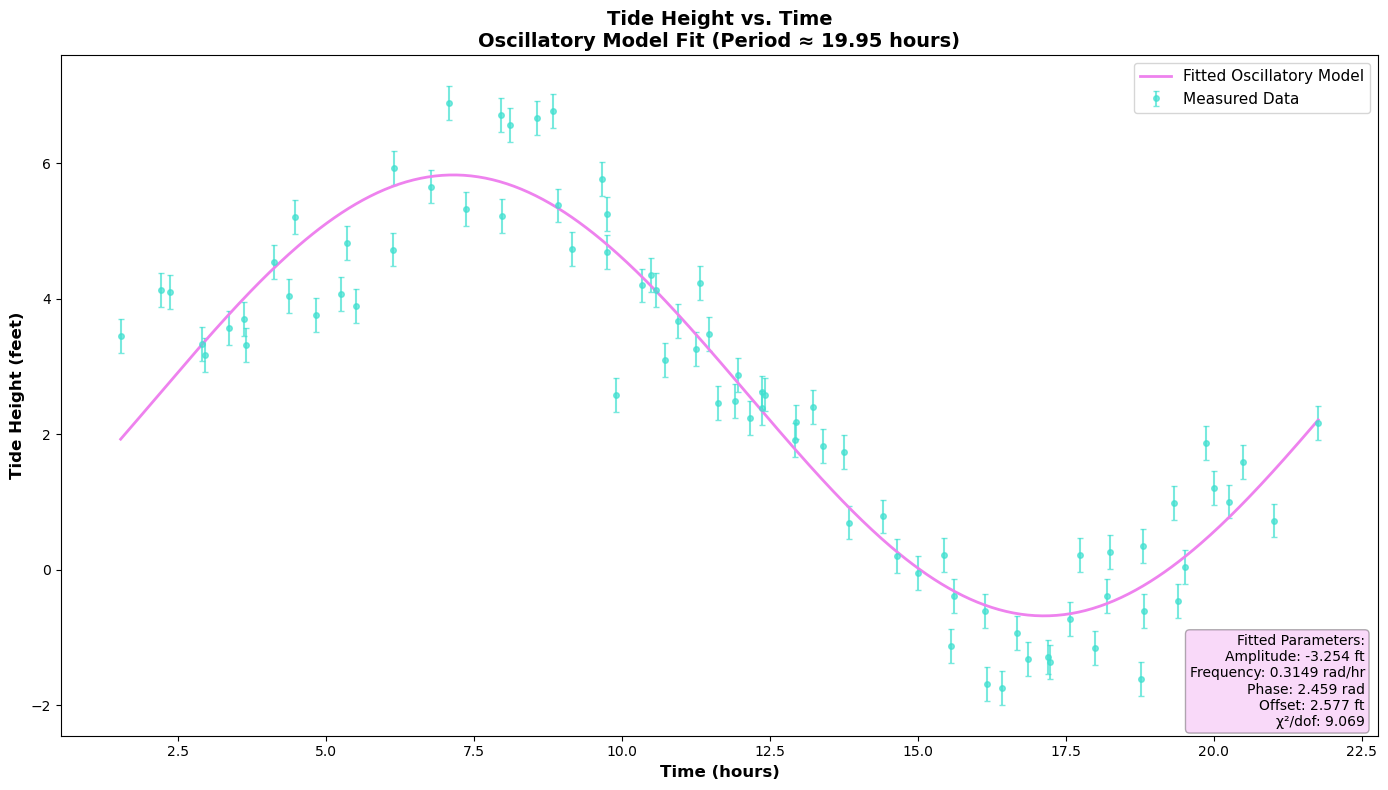

In [12]:
# Create comprehensive plot with data and fitted model
fig, ax = plt.subplots(figsize=(14, 8))

# Plot the raw data with error bars
ax.errorbar(
    x_data, 
    y_data, 
    yerr=np.full_like(x_data, sigma),
    fmt='o', 
    label='Measured Data', 
    markersize=4,
    capsize=2,
    alpha=0.7,
    color='turquoise'
)

# Plot the fitted model as a smooth curve
x_smooth = np.linspace(np.min(x_data), np.max(x_data), 500)
y_smooth = oscillatory_model(x_smooth, *popt)
ax.plot(
    x_smooth, 
    y_smooth, 
    '-', 
    label='Fitted Oscillatory Model', 
    linewidth=2,
    color='violet'
)

# Add labels and title
ax.set_xlabel('Time (hours)', fontsize=12, fontweight='bold')
ax.set_ylabel('Tide Height (feet)', fontsize=12, fontweight='bold')
ax.set_title(f'Tide Height vs. Time\nOscillatory Model Fit (Period ≈ {2*np.pi/frequency_fit:.2f} hours)',
             fontsize=14,fontweight='bold',color='black'
)

# Add grid for clarity
ax.grid(True, color='white', linestyle='--')

# Add legend
ax.legend(fontsize=11, loc='best')

# Add fitted parameters as text on the plot
textstr = f'Fitted Parameters:\n' \
          f'Amplitude: {amplitude_fit:.3f} ft\n' \
          f'Frequency: {frequency_fit:.4f} rad/hr\n' \
          f'Phase: {phase_fit:.3f} rad\n' \
          f'Offset: {offset_fit:.3f} ft\n' \
          f'χ²/dof: {reduced_chi_squared:.3f}'

ax.text(
    0.99, 0.01, 
    textstr, 
    transform=ax.transAxes,
    fontsize=10,
    verticalalignment='bottom',
    horizontalalignment='right',
    color='black',
    bbox=dict(boxstyle='round', facecolor='violet', alpha=0.3)
)

plt.tight_layout()
pdf_filename = "tide_model_fit.pdf"
plt.savefig(pdf_filename, format='pdf', dpi=300, bbox_inches='tight')
print(f"\nFigure saved to '{pdf_filename}'")
plt.show()